# A Simple Example on Creating a Custom Refutation Using User-Defined Outcome Functions
In this experiment, we define a linear dataset. In order to find the coefficients, we make use of the linear regression estimator. In order to test the effectiveness of the linear estimator, we now replace the outcome value with a dummy produced with the help of a linear expression based on the value of the confounders. This effectively means that the effect of the treatment on the outcome should be zero. This is exactly, what we should expect from the results of the refuter.

## Insert Dependencies

In [14]:
from dowhy import CausalModel
import dowhy.datasets
import pandas as pd
import numpy as np
import logging

## Create the Dataset
You can change the values of the hyper params to see how the effects change, as each parameter changes
Variable Guide:

| Variable Name   | Data Type |  Interpretation    |
|-----------------|-----------|--------------------|
|   $Z_i$         |  float    | Insrument Variable |
|   $W_i$         |  float    | Confounder         |
|   $v_0$         |  float    | Treatment          |
|    $y$          |  float    | Outcome            |



In [10]:
# Value of the coefficient [BETA]
BETA = 10
# Number of Common Causes
NUM_COMMON_CAUSES = 2
# Number of Instruments
NUM_INSTRUMENTS = 1
# Number of Samples
NUM_SAMPLES = 100000
# Treatment is Binary
TREATMENT_IS_BINARY = False
data = dowhy.datasets.linear_dataset(beta=BETA,
                                 num_common_causes=NUM_COMMON_CAUSES,
                                 num_instruments=NUM_INSTRUMENTS,
                                 num_samples=NUM_SAMPLES,
                                 treatment_is_binary=TREATMENT_IS_BINARY)
data['df'].head()

,Z0,W0,W1,v0,y
0,0.0,-1.086265,0.566131,-4.817235,-51.000055
1,1.0,-1.446155,1.078949,2.891889,26.582560
2,1.0,0.387138,1.052355,12.759312,134.107854
3,0.0,0.440114,0.628057,1.892234,23.833082
4,1.0,-0.116181,-1.617984,8.543409,77.761051


## Creating the Causal Model

In [15]:
model = CausalModel(
    data = data['df'],
    treatment = data['treatment_name'],
    outcome = data['outcome_name'],
    graph = data['gml_graph'],
    instruments = data['instrument_names'],
    logging_level = logging.INFO
)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


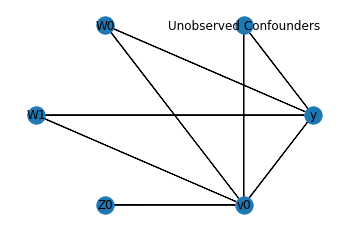

In [18]:
model.view_model()

In the above figure, we have a causal graph that shows the relationships between the treatment, outcome, confounders and the instrument variable.
- The Confounders $W_0$ and $W_1$ affect both the treatment and the outcome
- The instrument variable $Z_0$ is able to effect the outcome $y$ through the treatment $x$

## Identify the Estimand

In [20]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W1', 'W0', 'Unobserved Confounders']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|W1,W0))
d[v₀]                      
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0])*Derivative([v0], [Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)



## Estimating the Effect

In [22]:
causal_estimate = model.estimate_effect( identified_estimand,
                                       method_name="iv.instrumental_variable",
                                       method_params={'iv_instrument_name':'Z0'}
                                       )
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|W1,W0))
d[v₀]                      
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0])*Derivative([v0], [Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)
Estimand assumption 3, treatment_effect_homo

# Refuting the Estimate

## Using a Randomly Generated Value

In [24]:
ref = model.refute_estimate(identified_estimand,
                           causal_estimate,
                           method_name="dummy_outcome_refuter"
                           )
print(ref)

INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                          -1
Expectation(Derivative(dummy_outcome, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and dummy_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome dummy_outcome is affected in the same way by common causes of ['v0'] and dummy_outcome

INFO:dowhy.causal_refuters.dummy_outcome_refuter:Making use of Bootstrap as we have mor

Refute: Use a Dummy Outcome
Estimated effect:10.006229589077737
New effect:2.0838738761455298e-06
p value:0.99



The result shows that the treatment does not lead to the outcome. The esitimated outcome $2x10^{-6}$ is a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the estimator correctly predicts that the influence if treatment is Zero.

## Using a Function that Generates the Outcome from the Confounders

Let us define a simple function that generates the outcome as a linear function of the confounders.

In [26]:
coefficients = np.array([1,2])
bias = 3
def linear_gen(df):
    y_new = np.dot(df[['W0','W1']].values,coefficients) + 3
    return y_new

The basic expression is of the form
$y_{new} = \beta_0W_0 + \beta_1W_1 + \gamma_0$

where,
$\beta_0=1$, $\beta_1=2$ and $\gamma_0=3$

In [28]:
ref = model.refute_estimate(identified_estimand,
                           causal_estimate,
                           method_name="dummy_outcome_refuter",
                           outcome_function=linear_gen
                           )

print(ref)

INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                          -1
Expectation(Derivative(dummy_outcome, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and dummy_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome dummy_outcome is affected in the same way by common causes of ['v0'] and dummy_outcome

INFO:dowhy.causal_refuters.dummy_outcome_refuter:Making use of Bootstrap as we have mor

Refute: Use a Dummy Outcome
Estimated effect:10.006229589077737
New effect:-5.262651999486695e-06
p value:1.0



Like the previous experiment, we observe that the estimator shows that the effect of the treatment is Zero. The refuter confirms this as the value obtained through the refutation is $5x10^{-6}$ and has a p value of 1.0 across 100 simulations.